# ClusterFinder Reference genomes reconstruction

This notebook validates the 10 genomes we obtained from NCBI based on the ClusterFinder supplementary table. 

We check that the gene locations from the supplementary table match locations in the GenBank files.

In [1]:
from Bio import SeqIO
from Bio.SeqFeature import FeatureLocation
import pandas as pd
from Bio import Entrez
import seaborn as sns

def get_features_of_type(sequence, feature_type):
    return [feature for feature in sequence.features if feature.type == feature_type]

In [2]:
def get_reference_gene_location(gene_csv_row):
    start = gene_csv_row['gene start'] - 1
    end = gene_csv_row['gene stop']
    strand = 1 if gene_csv_row['gene strand'] == '+' else (-1 if gene_csv_row['gene strand'] == '-' else None)
    return FeatureLocation(start, end, strand)

def feature_locus_matches(feature, reference_locus):
     return feature.qualifiers.get('locus_tag',[None])[0] == reference_locus

# Loading reference cluster gene locations

In [3]:
reference_genes = pd.read_csv('../data/clusterfinder/labelled/CF_labelled_genes_orig.csv', sep=';')
reference_genes.head()

,NCBI ID,Genome ID,contig id,NPL start,NPL stop,NPL strand,gene id,gene locus,gene name,gene start,gene stop,gene strand
0,KK037166.1,Kutzneria_sp_744,"7,00E+15",28901,43059,+,"7,00E+15",KUTG_00017,"lysine 2,3-aminomutase",28901,30310,-
1,KK037166.1,Kutzneria_sp_744,"7,00E+15",28901,43059,+,"7,00E+15",KUTG_00018,"alcohol dehydrogenase, zinc-containing",30404,31462,+
2,KK037166.1,Kutzneria_sp_744,"7,00E+15",28901,43059,+,"7,00E+15",KUTG_00019,amidohydrolase 3,31459,33072,+
3,KK037166.1,Kutzneria_sp_744,"7,00E+15",28901,43059,+,"7,00E+15",KUTG_00020,"beta-lysine 5,6-aminomutase",33069,34637,+
4,KK037166.1,Kutzneria_sp_744,"7,00E+15",28901,43059,+,"7,00E+15",KUTG_00021,"beta-lysine 5,6-aminomutase",34634,35383,+


# Genes with no sequence

In [4]:
no_sequence_genes = reference_genes[reference_genes['NCBI ID'] == '?']
no_sequence_counts = no_sequence_genes.groupby('Genome ID')['gene locus'].count()
print('{} genes don\'t have a sequence!'.format(len(no_sequence_genes)))
pd.DataFrame({'missing genes':no_sequence_counts})

421 genes don't have a sequence!


,missing genes
Genome ID,
Micromonospora_M42_V1,1
StrRos_NRRL11379_V1,420


In [6]:
reference_ids = reference_genes[reference_genes['NCBI ID'] != '?']['NCBI ID'].unique()
reference_ids

array(['KK037166.1', 'GG657738.1', 'KK037233.1', 'DS999642.1',
       'DS999641.1', 'DS999645.1', 'GG657754.1', 'CM000950.1',
       'GG657747.1', 'GG657746.1', 'GG657751.1', 'GG657750.1',
       'GG657752.1'], dtype=object)

# Validating that reference genes are found in our sequences

In [7]:
def validate_genome(record, record_reference_genes):
    print('Validating {}'.format(record.id))
    record_genes = get_features_of_type(record, 'gene')
    record_cds = get_features_of_type(record, 'CDS')
    validation = []
    record_length = len(record.seq)
    min_location = record_length
    max_location = -1
    prev_gene_index = None
    prev_cluster_start = None
    for i, reference_gene in record_reference_genes.iterrows():
        reference_gene_location = get_reference_gene_location(reference_gene)
        reference_gene_locus = reference_gene['gene locus']
        reference_cluster_start = reference_gene['NPL start']
        gene_matches_locus = [f for f in record_genes if feature_locus_matches(f, reference_gene_locus)]
        cds_matches_locus = [f for f in record_cds if feature_locus_matches(f, reference_gene_locus)]
        gene_matches_location = [f for f in gene_matches_locus if reference_gene_location == f.location]
        cds_matches_location = [f for f in cds_matches_locus if reference_gene_location == f.location]
        validation.append({
            'gene_locus_not_found':not gene_matches_locus, 
            'cds_locus_not_found':not cds_matches_locus, 
            'gene_location_correct': bool(gene_matches_location), 
            'cds_location_correct': bool(cds_matches_location)
        })
        if not cds_matches_locus:
            print('No CDS found for gene locus {}'.format(reference_gene_locus))
        if gene_matches_locus:
            gene_match = gene_matches_locus[0]
            if not cds_matches_locus:
                print(' Gene: ', gene_match.qualifiers)
                
            # Use gene index to check if we have a consecutive sequence of genes (except when going from one cluster to another)
            gene_index = [gi for gi,f in enumerate(record_genes) if feature_locus_matches(f, reference_gene_locus)][0]
            if reference_cluster_start == prev_cluster_start and gene_index != prev_gene_index + 1:
                print('Additional unexpected genes found before {} (index {} -> {}) at cluster start {}'.format(reference_gene_locus, prev_gene_index, gene_index, reference_cluster_start))
            
            # Calculate min and max cluster gene location to see how much of the sequence is covered by the reference genes
            min_location = min(gene_match.location.start, min_location)
            max_location = max(gene_match.location.end, max_location)
            prev_gene_index = gene_index
        prev_cluster_start = reference_cluster_start
           
    result = pd.DataFrame(validation).sum().to_dict()
    result['location correct'] = min(result['gene_location_correct'], result['cds_location_correct']) / len(validation)
    result['ID'] = record.id
    result['genome'] = record_reference_genes.iloc[0]['Genome ID']
    result['sequence length'] = record_length
    result['total genes'] = len(record_genes)
    result['reference genes'] = len(record_reference_genes)
    result['first location'] = min_location / record_length
    result['last location'] = max_location / record_length
    result['covered'] = (max_location - min_location) / record_length
    return result

In [8]:
validations = []
reference_gene_groups = reference_genes.groupby('NCBI ID')
records = SeqIO.parse('../data/clusterfinder/labelled/CF_labelled_contigs.gbk', 'genbank')
for record in records:
    ncbi_id = record.id
    print(ncbi_id)
    record_reference_genes = reference_gene_groups.get_group(ncbi_id)
    validations.append(validate_genome(record, record_reference_genes))
validations = pd.DataFrame(validations)
validations.set_index('ID', inplace=True)
validations

CM000950.1
Validating CM000950.1
No CDS found for gene locus SSDG_00035
 Gene:  OrderedDict([('locus_tag', ['SSDG_00035']), ('note', ['ABC transporter; frameshift'])])
No CDS found for gene locus SSDG_00089
 Gene:  OrderedDict([('locus_tag', ['SSDG_00089']), ('note', ['squalene/phytoene dehydrogenase; frameshift'])])
No CDS found for gene locus SSDG_04325
 Gene:  OrderedDict([('locus_tag', ['SSDG_04325']), ('note', ['AMP-dependent synthetase and ligase; frameshift'])])
No CDS found for gene locus SSDG_06129
 Gene:  OrderedDict([('locus_tag', ['SSDG_06129']), ('note', ['transferase; frameshift'])])
No CDS found for gene locus SSDG_06352
 Gene:  OrderedDict([('locus_tag', ['SSDG_06352']), ('note', ['predicted protein; frameshift'])])
No CDS found for gene locus SSDG_00185
 Gene:  OrderedDict([('locus_tag', ['SSDG_00185']), ('note', ['glycosyl transferase; frameshift'])])
No CDS found for gene locus SSDG_06509
 Gene:  OrderedDict([('locus_tag', ['SSDG_06509']), ('note', ['beta keto-acyl s

,cds_location_correct,cds_locus_not_found,covered,first location,gene_location_correct,gene_locus_not_found,genome,last location,location correct,reference genes,sequence length,total genes
ID,,,,,,,,,,,,
CM000950.1,300,10,0.972233,0.010094,310,0,Strept_priATCC25486_V1,0.982327,0.884956,339,8133379,7077
DS999641.1,281,0,0.983626,0.008382,290,0,S.ghanaensis_ATCC14672_V1,0.992008,0.939799,299,8265412,7729
DS999642.1,93,0,0.873147,0.107535,93,0,S.ghanaensis_ATCC14672_V1,0.980682,1.000000,93,231283,211
DS999645.1,264,0,0.999363,0.000624,275,0,StrAlb_J1074_V3,0.999988,0.901024,293,6813830,5955
GG657738.1,462,0,0.944454,0.048209,483,0,Micro_carb_varATCC39149,0.992663,0.925852,499,6798591,5662
GG657746.1,266,0,0.932882,0.004900,269,0,Strept_sp_AA4,0.937782,0.988848,269,8475969,7789
GG657747.1,39,0,0.557014,0.343816,39,0,Strept_sp_AA4,0.900830,1.000000,39,327015,327
GG657750.1,212,0,0.945454,0.046865,219,0,Strept_sp_C,0.992320,0.909871,233,7450102,6740
GG657751.1,43,0,0.691226,0.302906,43,0,Strept_sp_C,0.994132,0.955556,45,625386,616


In [9]:
validations['location correct'].mean()

0.9267887842574284

In [15]:
1 - validations['location correct'].mean()

0.07321121574257161

In [11]:
validations[['genome','first location','last location','covered','location correct','reference genes','total genes']]

,genome,first location,last location,covered,location correct,reference genes,total genes
ID,,,,,,,
CM000950.1,Strept_priATCC25486_V1,0.010094,0.982327,0.972233,0.884956,339,7077
DS999641.1,S.ghanaensis_ATCC14672_V1,0.008382,0.992008,0.983626,0.939799,299,7729
DS999642.1,S.ghanaensis_ATCC14672_V1,0.107535,0.980682,0.873147,1.000000,93,211
DS999645.1,StrAlb_J1074_V3,0.000624,0.999988,0.999363,0.901024,293,5955
GG657738.1,Micro_carb_varATCC39149,0.048209,0.992663,0.944454,0.925852,499,5662
GG657746.1,Strept_sp_AA4,0.004900,0.937782,0.932882,0.988848,269,7789
GG657747.1,Strept_sp_AA4,0.343816,0.900830,0.557014,1.000000,39,327
GG657750.1,Strept_sp_C,0.046865,0.992320,0.945454,0.909871,233,6740
GG657751.1,Strept_sp_C,0.302906,0.994132,0.691226,0.955556,45,616


# Cluster genes

In [12]:
genes = pd.read_csv('../data/clusterfinder/labelled/CF_labelled_genes.csv', sep=';')
genes.head()

,contig_id,contig_source,cluster_id,cluster_strand,locus_tag,gene_label
0,KK037166.1,Kutzneria_sp_744,Kutzneria_sp_744_28901-43059,+,KUTG_00017,"lysine 2,3-aminomutase"
1,KK037166.1,Kutzneria_sp_744,Kutzneria_sp_744_28901-43059,+,KUTG_00018,"alcohol dehydrogenase, zinc-containing"
2,KK037166.1,Kutzneria_sp_744,Kutzneria_sp_744_28901-43059,+,KUTG_00019,amidohydrolase 3
3,KK037166.1,Kutzneria_sp_744,Kutzneria_sp_744_28901-43059,+,KUTG_00020,"beta-lysine 5,6-aminomutase"
4,KK037166.1,Kutzneria_sp_744,Kutzneria_sp_744_28901-43059,+,KUTG_00021,"beta-lysine 5,6-aminomutase"


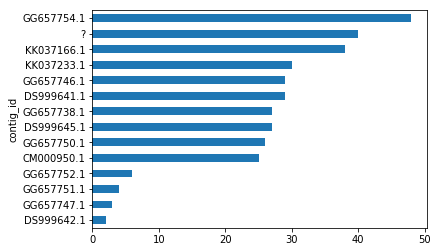

In [13]:
cluster_counts = genes.groupby('contig_id')['cluster_id'].nunique()
cluster_counts.sort_values().plot.barh()

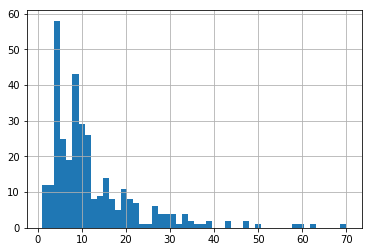

In [14]:
gene_counts = genes.groupby('cluster_id')['locus_tag'].count()
gene_counts.hist(bins=50)